**Diagnostiquer la pneumonie à l'aide des rayons X**

Les radiographies permettent de voir les signes de pneumonie et ainsi de confirmer le diagnostic, ainsi que d'identifier le type et le stade de la maladie. Contrairement à d’autres méthodes de diagnostic, à l’efficacité prouvée, les radiographies sont plus accessibles. Cependant, comme les signes de pneumonie et d’autres maladies pulmonaires sur les radiographies sont similaires, ce type d’étude ne constitue qu’une partie d’un diagnostic complet.

Pour diagnostiquer, un spécialiste a besoin de:

Forme et taille des champs pulmonaires (dans les limites normales ou noter les écarts par rapport à la norme)
Les champs pulmonaires sont transparents ou des écarts par rapport à la norme sont détectés sous la forme de : ombres, dégagements, symptômes d'ombres mixtes.
Etude du profil pulmonaire (amélioré, appauvri ou normal)
Le modèle neuronal n'a pas besoin de ces données. Il ne nécessite pas un examen approfondi de l’image, le diagnostic sera annoncé instantanément. Mais vous devez d’abord le construire et le former. La base de notre modèle sera ResNet50, capable de traiter des problèmes d'un ordre de grandeur plus complexes que le nôtre.

In [55]:

!pip install tensorflow==2.2.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.15.0rc0, 2.15.0rc1)
ERROR: No matching distribution found for tensorflow==2.2.0


#Import des librairies et fonctions nécessaires

In [1]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Chargement du dataset de kaggle


In [2]:
#importer le fichier kaggle.ison qui contient le token
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhilout","key":"5d683ee799949a189279998af108cf88"}'}

In [3]:
# déplacer kaggle.json dans la route .kaggle et définir les permissions du ficher.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia



 99% 2.27G/2.29G [00:21<00:00, 69.7MB/s]
100% 2.29G/2.29G [00:21<00:00, 112MB/s] 


In [5]:
# Décomprésser
!unzip -q chest-xray-pneumonia.zip


# Définir les paramètres

In [38]:
class_names = ['NORMAL', 'PNEUMONIA']
nb_classes = len(class_names)
image_size = (120, 120)
batch_size = 16


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# dataset = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia'
# train_data_dir = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/train'
# test_data_dir = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/test'
# # validation_data_dir =




# Prétraitement des données :
# Augmentation et resize.
L'augmentation est très limitée dans ce cas car les images de radiographie sont standardisées (pas de rotaion possible par exemple).

In [48]:


train_dir = './chest_xray/train'
validation_dir = './chest_xray/val'
test_dir = './chest_xray/test'

train_datagen = ImageDataGenerator(rescale=1.0/255)
test_val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_val_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size= batch_size,
    class_mode='binary')

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [49]:

train_normal = len(os.listdir(os.path.join(train_dir, "NORMAL")))
train_pneumonia = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))

test_normal = len(os.listdir(os.path.join(test_dir, "NORMAL")))
test_pneumonia = len(os.listdir(os.path.join(test_dir, "PNEUMONIA")))

validation_normal = len(os.listdir(os.path.join(validation_dir, "NORMAL")))
validation_pneumonia = len(os.listdir(os.path.join(validation_dir, "PNEUMONIA")))

<function matplotlib.pyplot.show(close=None, block=None)>

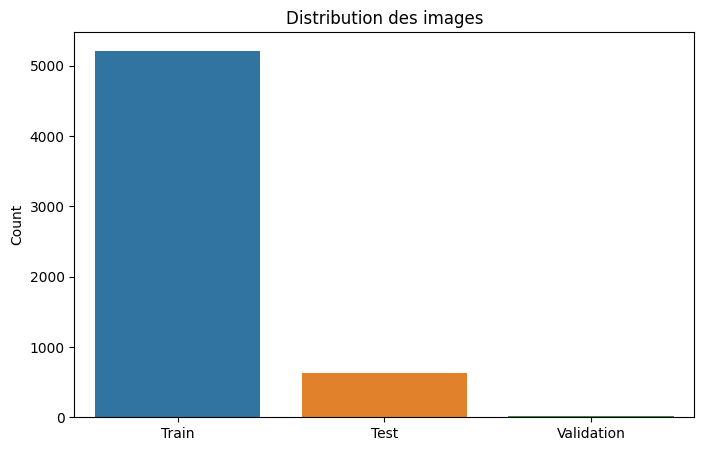

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(x=["Train", "Test", "Validation"], y=[train_normal + train_pneumonia, test_normal + test_pneumonia, validation_normal + validation_pneumonia])
plt.title("Distribution des images")
plt.ylabel("Count")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

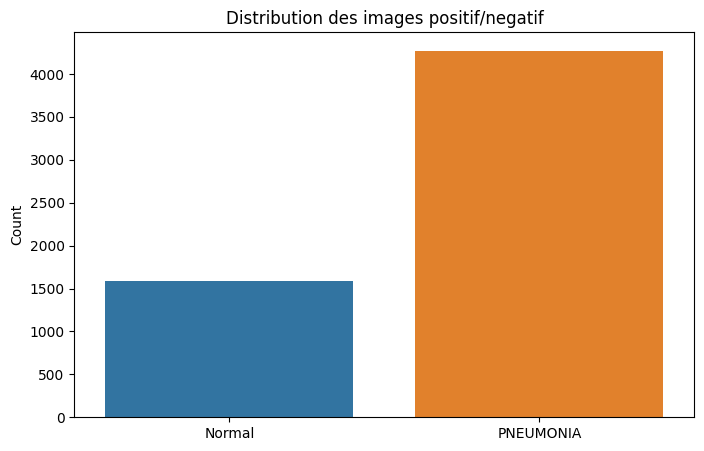

In [11]:
plt.figure(figsize=(8, 5))
sns.barplot(x=["Normal", "PNEUMONIA"], y=[train_normal + test_normal+ validation_normal, train_pneumonia + test_pneumonia + validation_pneumonia])
plt.title("Distribution des images positif/negatif")
plt.ylabel("Count")
plt.show

Nous constatons que le dataset est très **désequilibré**, nous allons procéder par des techniques afin de favoriser la classe minoritaire(NORMAL) par une data-augmentation enrichie et des parametres de poids diffents dans les algorithmes.

Visualisation d'images

TypeError: ignored

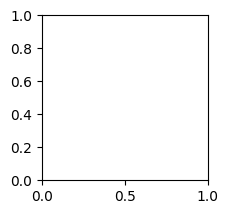

In [41]:
plt.figure(figsize=(15,15))
for n,i in enumerate(list(np.random.randint(0,train_pneumonia,36))):
    plt.subplot(6,6,n+1)
    plt.imshow(train_pneumonia[i])
    plt.axis("off")

# Construction du model CNN


In [31]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), input_shape=(image_size[0], image_size[1], 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Répéter les couches Conv2D et MaxPooling2D selon les besoins

# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])


In [ ]:
# Model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 59, 59, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 128)      

#Entrainnement du model

In [57]:


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/30
326/326 [==============================] - 48s 142ms/step - loss: 0.3538 - accuracy: 0.8447 - val_loss: 0.4575 - val_accuracy: 0.8750
Epoch 2/30
326/326 [==============================] - 45s 139ms/step - loss: 0.1531 - accuracy: 0.9438 - val_loss: 0.5418 - val_accuracy: 0.7500
Epoch 3/30
326/326 [==============================] - 47s 143ms/step - loss: 0.1192 - accuracy: 0.9559 - val_loss: 0.5308 - val_accuracy: 0.7500
Epoch 4/30
326/326 [==============================] - 50s 153ms/step - loss: 0.1044 - accuracy: 0.9617 - val_loss: 0.2161 - val_accuracy: 0.9375
Epoch 5/30
326/326 [==============================] - 45s 138ms/step - loss: 0.0971 - accuracy: 0.9636 - val_loss: 0.5400 - val_accuracy: 0.8125
Epoch 6/30
326/326 [==============================] - 45s 139ms/step - loss: 0.0853 - accuracy: 0.9709 - val_loss: 0.5369 - val_accuracy: 0.8125
Epoch 7/30
326/326 [==============================] - 47s 143ms/step - loss: 0.0905 - accuracy: 0.9693 - val_loss: 0.5487 - val_ac

In [51]:
# equilibrer les classes
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes)
class_weights = dict(enumerate(class_weights))



In [56]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=int(round(train_generator.samples/ batch_size)),
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=int(round(validation_generator.samples / batch_size)),
#     class_weight=class_weights)

# steps_per_epoch = 163  # Remplacez 326 par la valeur appropriée calculée séparément
# validation_steps = 16  # Remplacez 16 par la valeur appropriée calculée séparément

# history = model.fit(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=validation_steps
)


Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9709

TypeError: ignored

In [16]:
print(train_generator.samples)


5216


In [29]:
steps_per_epoch = train_generator.samples // batch_size
print(steps_per_epoch)


163


5216


# Evaluation du modèle

In [60]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples)
print('Test accuracy:', test_acc)


 39/624 [>.............................] - ETA: 1:16 - loss: 1.8374 - accuracy: 0.7885

624/624 [==============================] - 5s 8ms/step - loss: 1.8374 - accuracy: 0.7885
Test accuracy: 0.7884615659713745


39/39 [==============================] - 6s 127ms/step


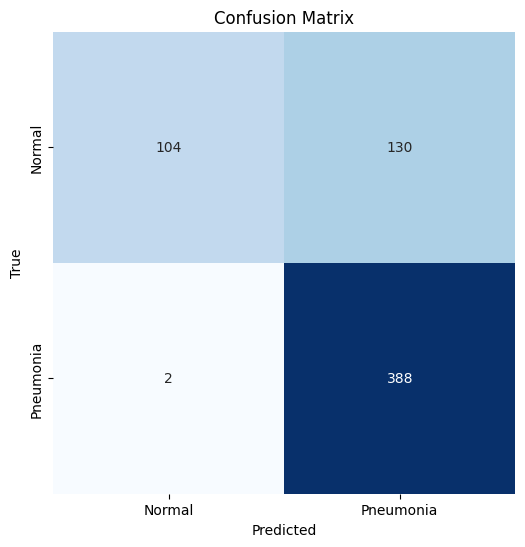

In [62]:
# Results
# test_results = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
# print("Test Loss:", test_results[0])
# print("Test Accuracy:", test_results[1])

predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)

# print(classification_report(test_generator.classes, y_pred, target_names=["Normal", "Pneumonia"]))
confusion_mtx = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualisation de l'accuracy


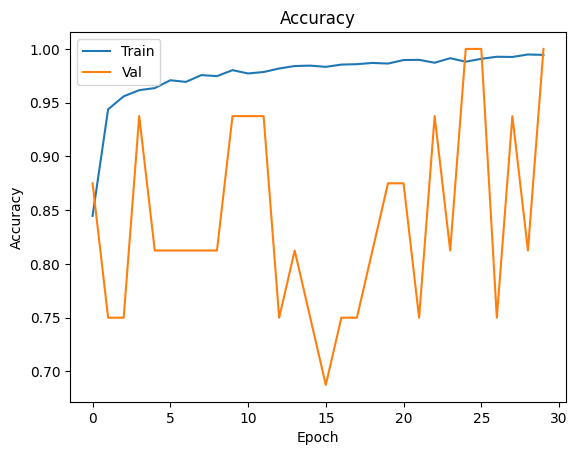

In [65]:
# Visualisation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [64]:
# Sauvegarder le modèle
model.save('model1_pneumonia.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
